In [30]:
!python --version

Python 3.9.10


In [31]:
import torch
torch.__version__

'1.12.1+cu116'

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Setup directory paths to train and test images
train_dir = 'D:/Codes/Engine/chess_pgn_to_bitboard/train'
test_dir = 'D:/Codes/Engine/chess_pgn_to_bitboard/test'

In [ ]:
import numpy as np

def chess_fen_to_img(fen:str):
    '''
    Generate a bitboard that has Black and White channels for each piece, i.e.,
    6 channel array of board, each channel representing position of one kind of chess-piece.
    One each for King, Queen, Rook, Bishop, Knight and Pawn in order.
    FEN position of example board: r4r2/3p2kp/bp1Nppp1/p1p1n3/2P5/1q1BR1Q1/5PPP/3R2K1
    There are other trailing parts of the FEN string, but the relevant part here is written, 
    as we ignore the rest for the purpose of this function.
    '''
    arr = 255*np.ones((6,224,224))
    piece_patch = np.zeros((28,28))
    count = 0
    fen_piece_loc = fen.split()[0]
    for char in fen_piece_loc:
        y = count // 8
        x = count % 8
        match char:
            case 'p':
                arr[5, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'n':
                arr[4, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'b':
                arr[3, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'r':
                arr[2, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'q':
                arr[1, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'k':
                arr[0, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch

            case 'P':
                arr[5, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'N':
                arr[4, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'B':
                arr[3, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'R':
                arr[2, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'Q':
                arr[1, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch
            case 'K':
                arr[0, 28*x:28*(x+1)-1, 28*y:28*(y+1)-1] = piece_patch

            case '/':
                count -= 1
        if char.isnumeric():
            count += int(char)-1
        count += 1


    return arr

In [4]:
import os
import csv

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir)
  test_data = datasets.ImageFolder(test_dir)

  # Get class names
  truth_values = csv.read('eval.csv')

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, truth_values

In [5]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

In [14]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of channels for the input images. Defaults to 6.
        patch_size (int): Number of patches to convert input image into. Defaults to 8.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=6,
                 patch_size:int=28,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# Let's test it on single image
patch_size = 28

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=6,
                          patch_size=28,
                          embedding_dim=768)

In [17]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 28

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=6,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


Image tensor shape: torch.Size([6, 224, 224])
Input image with batch dimension shape: torch.Size([1, 6, 224, 224])
Patching embedding shape: torch.Size([1, 392, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 393, 768])
Patch and position embedding shape: torch.Size([1, 393, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2555,  0.0979, -0.1066,  ...,  0.1856, -0.0969,  0.0531],
         [-0.2085,  0.0944, -0.1383,  ...,  0.1885, -0.1067,  0.1353],
         ...,
         [-0.2683,  0.0948, -0.0974,  ...,  0.1550, -0.1015,  0.0208],
         [-0.1859, -0.0240, -0.0559,  ...,  0.0585, -0.0334,  0.1036],
         [-0.2540,  0.0659, -0.0517,  ...,  0.0708,  0.0295,  0.0389]]],
       grad_fn=<CatBackward0>)


In [18]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [20]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [22]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x
    


In [23]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 393, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 393, 768]        [1, 393, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 393, 768]        [1, 393, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 393, 768]        [1, 393, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 393, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 393, 768]        [1, 393, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 393, 768]        [1, 393, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 393, 768]        [1, 393, 768]        --                   True
│    │    └─Linear (0)                     

In [24]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=6, # Number of channels in input image, 6 bit-boards for each type of chess-piece.
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [ ]:
class CNN_ViT(nn.Module):
    """Creates a CNN layer in front of the ViT model"""
    
    # Creating 6 convolutional filters similar to the bitboards for individual pieces.
    # Input is 6-channel image from the chessboard, in form of upscaled bit boards, one for each kind of piece.
    def __init__(self,
                 k_size:int=5,
                 padding:int=2,
                 num_kernels:int=6): 
        super().__init__()

        # Create a Convolutional Layer ahead of the vision transformer.
        self.conv = nn.LazyConv2d(out_channels=num_kernels,
                              kernel_size=k_size,
                              padding=padding)
        
        # Supplement the Convolutional Layer with MaxPooling ahead of the vision transformer.
        self.pool =  nn.MaxPool2d(kernel_size=k_size)
        
        # Pass the pooled output to the transformer.
        self.vit = ViT()
    
    
    def forward(self, x):

        # Convolutions and pooling.
        x =  self.conv(x) 

        x = self.pool(x)
        
        # Vision Transformer in action.
        x = self.vit(x)

        return x

In [25]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
cnn_vit_net = CNN_ViT(num_classes=len(class_names))


In [ ]:
from prep_tools import training

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=cnn_vit_net.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = training.train(model=cnn_vit_net,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

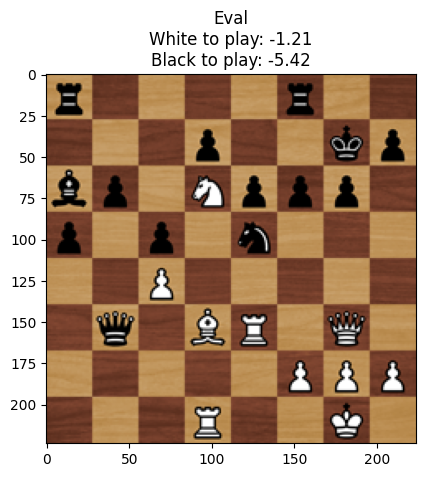

Eval - White to play StockFish Eval: -1.63
Eval - Black to play Stockfish Eval: -6.73


In [29]:
# Setup custom board path
custom_fen = "r4r2/3p2kp/bp1Nppp1/p1p1n3/2P5/1q1BR1Q1/5PPP/3R2K1"

custom_image = chess_fen_to_img(custom_fen)

# Predict on custom board
pred_and_plot_image(model=cnn_vit_net,
                    image_path=custom_image,
                    class_names=class_names)

# Known eval for the given board position
print('Eval - White to play StockFish Eval: -1.63')
print('Eval - Black to play Stockfish Eval: -6.73')